# Dependencies

In [5]:
#%% dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# ML and AI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import Adam

# Custom LSTM Model + LRP
from LSTM import *
from Preprocessing import process_data_with_factors, prepare_data_for_training

# Plotting and Graphs
import plotly.graph_objects as go

2023-07-23 16:42:28.255239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 16:42:28.557541: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 16:42:28.559310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 16:42:30.154075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Fama French - Data Preparation 

In [8]:
# read in factor data as pd.dataframe
factors = pd.read_csv("./data/PredictorLSretWide.csv")

# format date column
factors["date"] = pd.to_datetime(factors["date"])

# filter factors for relevant period
factors = factors.loc[ factors['date'] >= pd.to_datetime('1990-01-01'), : ]  

# read in factor data as pd.dataframe
factors = pd.read_csv("./data/F-F_Research_Data_Factors.CSV", delimiter=",", skiprows=3, nrows=1163)

# rename the Date column
factors.rename(columns={factors.columns[0]: 'Date'}, inplace=True)

# convert Date column to datetime object with pandas
factors["Date"] = pd.to_datetime(factors["Date"],format="%Y%m")

# Download stock data for Apple (AAPL)
aapl = yf.download('AAPL', start='1990-01-01', end='2023-06-01')

# Download stock data for the SP500 etf SPX
sp500 = yf.download('^SPX', start='1990-01-01', end='2023-06-01')

# Resample to monthly frequency and calculate monthly returns
aapl = aapl["Adj Close"].resample('M').last().pct_change().reset_index()
sp500 = sp500["Adj Close"].resample('M').last().pct_change().reset_index()

# Merge the AAPL Series and the factors DataFrame based on the index
aapl_with_factors = pd.merge(aapl, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
aapl = aapl_with_factors.set_index('Date')

# Merge the SP500 Series and the factors DataFrame based on the index
sp500_with_factors = pd.merge(sp500, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
sp500 = sp500_with_factors.set_index('Date')

aapl.rename(columns={"Adj Close": "Return"}, inplace=True)
sp500.rename(columns={"Adj Close": "Return"}, inplace=True)

# clean up
del sp500_with_factors, aapl_with_factors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Pre-Processing

After the data preperation is done, we can continue with

* splitting the data into train and test set

* scaling the data to ensure that all variables (predictor and response) are on the same scale

* re-shaping the data into a time series format that is suitable for the `tensorflow` LSTM network interface


In [9]:

# Define the data to train on
data = sp500

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)


# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Define X, y
X = data.drop(columns="Return").values
y = data["Return"].values

# ToDo: Normalise the Features and Response 

# Define the window size for one batch of data 
small_window_size = 5

# Create input sequences and response
sequences = []
response  = []

for i in range(small_window_size, len(X)):
    sequences.append(X[i-small_window_size:i])
    response.append(y[i])

# Convert the lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(response)

# Double check if batches were created correctly
#print(sequences[0])
#print(X[:window_size])

split_ratio = 1

split_index = int(split_ratio * len(sequences))

X_train = sequences[:split_index]
y_train = labels[:split_index]
X_test = sequences[split_index:]
y_test = labels[split_index:]

## Rolling Regression with LSTM model

  0%|          | 0/335 [00:00<?, ?it/s]2023-07-23 15:39:20.126103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 15:39:20.129352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-23 15:39:20.131471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore t

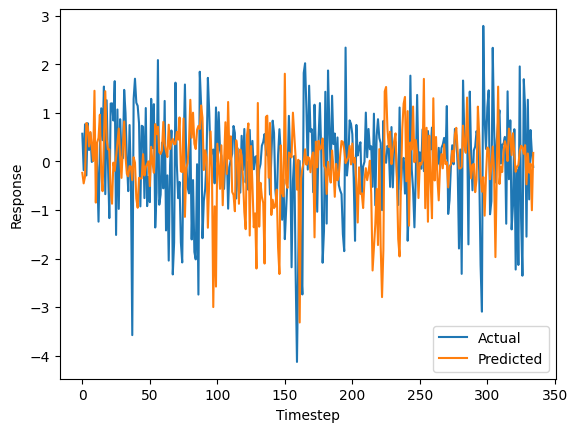

In [10]:
# Define the model
model = LSTMModel(50,3,5)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit rolling lstm model
predictions, relevance = model.rolling_fit(X_train, y_train, 60, 1/60, 5)

In [11]:
model.mse

1.7876861660371064

## LRP for our LSTM model

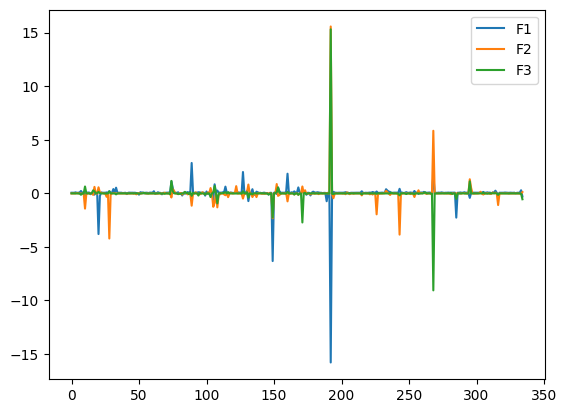

In [12]:
relevance_aggregated = np.mean(np.array(relevance), axis=1)

#plt.bar(height=np.abs(relevance_aggregated),x=["F1", "F2", "F3"])

from sklearn.preprocessing import scale


plt.plot(scale(relevance_aggregated), label=["F1", "F2", "F3"])
#plt.plot(y, label="response")
plt.legend()


---

# Deep Factor Model 

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/363 [00:00<?, ?it/s]2023-07-23 17:01:43.617473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 17:01:43.620021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-23 17:01:43.621905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore t

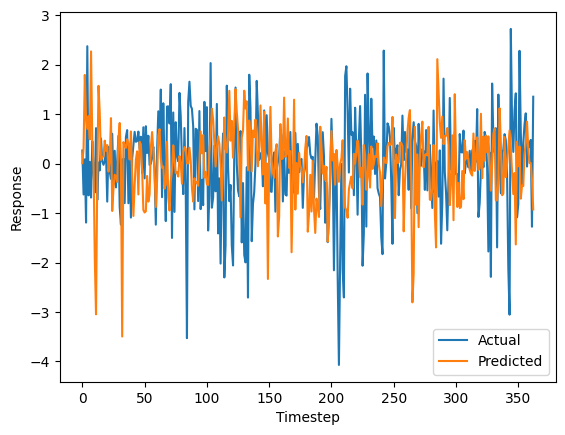

The MSE of the model:	 1.5663836561011384


In [14]:
# Define Path to File with factors
file_path = "./data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)

# Take the data frame and compute a data set of batches of size corresponding to a rolling time-step window of 5
X_train, y_train, X_test, y_test = prepare_data_for_training(data=sp500, small_window_size=5, split_ratio=1)


# Define the model
model = LSTMModel(lstm_units=64, input_dim=X_train.shape[2], timesteps=5)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit rolling lstm model
predictions, relevance = model.rolling_fit(X_train, y_train, 60, 1/60, 5)

print("The MSE of the model:\t", model.mse)

Text(0.5, 1.0, 'Factor Relevance (averaged over time)')

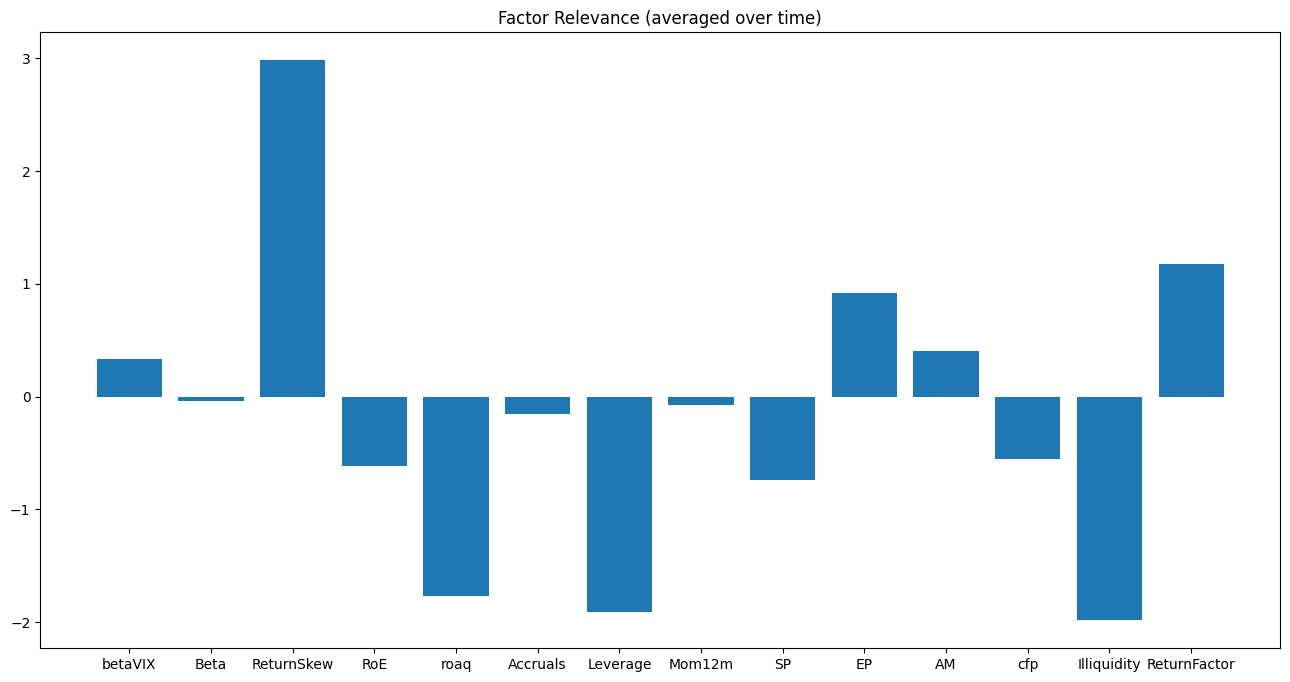

In [15]:
# Aggregate and Plot relevance over time

# Aggregate the relevance scores for all timesteps by taking the average
relevance_aggregated = np.mean(np.array(relevance), axis=1)


fig = go.Figure()

x = np.arange(relevance_aggregated.shape[0])  # Assume x-axis values are the same for all line plots

for i in range(relevance_aggregated.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=relevance_aggregated[:, i], mode='lines', name=(factor_selection + ["ReturnFactor"])[i]))
    
    
fig.update_layout(
    title='Multiple Line Plots',
    xaxis_title='Time',
    yaxis_title='Y-axis',
    legend_title='Lines'
)

fig.show()


plt.figure(figsize=(16,8))
plt.bar(height=relevance_aggregated.mean(axis=0), x=factor_selection + ["ReturnFactor"])
plt.title("Factor Relevance (averaged over time)")